# Setup a game

In [1]:
from ConnectN import ConnectN

# Initialize input board size and the winning condition
game_setting = {'size':(3,3), 'N':3}

# Initialize a ConnectN object
game = ConnectN(**game_setting)



In [2]:
game.move((0,1))
print(game.state)
print(game.player) # first player 1, and second player -1
print(game.score) # keep track socre(game is not over: None, draw: 0, first player won: 1, second player won: -1)

[[0. 1. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
-1
None


In [3]:
# player -1 move
game.move((0,0))
# player +1 move
game.move((1,1))
# player -1 move
game.move((1,0))
# player +1 move
game.move((2,1))

print(game.state)
print(game.player)
print(game.score)

[[-1.  1.  0.]
 [-1.  1.  0.]
 [ 0.  1.  0.]]
1
1


# Play a game interactively

<IPython.core.display.Javascript object>


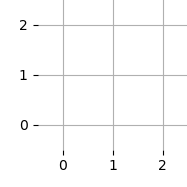

In [4]:
% matplotlib notebook

from Play import Play

# when player1 or player2 is None, it means they are from mouse click.
gameplay=Play(ConnectN(**game_setting), 
              player1=None, 
              player2=None)


# Initialize an AI to play the game
We need to define a policy for tic-tac-toe, that takes the game state as input, and outputs a policy and a critic

## Tentative Exercise:
Code up your own policy for training

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from math import *
import numpy as np
import random


class Policy(nn.Module):

    def __init__(self):
        super(Policy, self).__init__()
        
        
        '''
        NN contains both the policy and the critic
        
        1 input image channel, 16 output channels/feaure map(filter)
        output_dim = (W-F+2P)/S + 1
        
        Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, bias=True)
        Linear(in_features, out_features, bias=True)
        '''
        self.conv = nn.Conv2d(1, 16, kernel_size=2, stride=1, bias=False)
        self.size = 2*2*16 # input features: 16 outputs 2x2 filtered map size
        self.fc = nn.Linear(self.size,32)

        # layers for the policy
        self.fc_action1 = nn.Linear(32, 16)
        self.fc_action2 = nn.Linear(16, 9)
        
        # layers for the critic
        self.fc_value1 = nn.Linear(32, 8)
        self.fc_value2 = nn.Linear(8, 1)
        self.tanh_value = nn.Tanh()
        
    # feedforward behavior
    def forward(self, x):

        '''
        # Apply [CONV-RELU]
        # Flattening used for the output of conv/pooling layer to a linear layer (vector)
        '''
        y = F.relu(self.conv(x))   # Apply [CONV-RELU]
        y = y.view(-1, self.size)  # Flattening used for the output of conv/pooling layer to a linear layer
        y = F.relu(self.fc(y))     # One linear layer
        
        # you can easily use a softmax on a 9x9 matrix to get the prob. but this doesn't work quite that well.
        # Given that not all the moves are available because say, player one plays a piece in a position,
        # then player negative one could not place another piece in that same location.
        # To fix it, compute 'avial' called the availablility matrix, which basically gives zeros when
        # the move is unavailable in that location and it gives one when a move is available.
        # the action head
        a = F.relu(self.fc_action1(y))
        a = self.fc_action2(a)
        
        # availability of moves
        avail = (torch.abs(x.squeeze())!=1).type(torch.FloatTensor)
        avail = avail.reshape(-1,9)
#         avail = avail.view(-1, 9)
        
        # locations where actions are not possible, we set the prob to zero
        maxa = torch.max(a)
        
        # Softmax operation.
        # Doin this below will ensure that when a move is not legal, the prob will be exactly zero.
        # subtract off max for numerical stability (avoids blowing up at infinity)
        exp = avail*torch.exp(a-maxa)
        prob = exp/torch.sum(exp)
        
        # critic
        # the value head
        value = F.relu(self.fc_value1(y))
        value = self.tanh_value(self.fc_value2(value))
        return prob.view(3,3), value

# # we use the adam optimizer with learning rate 2e-4
# # optim.SGD is also possible
# import torch.optim as optim
policy = Policy()
# optimizer = optim.Adam(policy.parameters(), lr=1.e-4, weight_decay=1.e-4)
print(policy)

Policy(
  (conv): Conv2d(1, 16, kernel_size=(2, 2), stride=(1, 1), bias=False)
  (fc): Linear(in_features=64, out_features=32, bias=True)
  (fc_action1): Linear(in_features=32, out_features=16, bias=True)
  (fc_action2): Linear(in_features=16, out_features=9, bias=True)
  (fc_value1): Linear(in_features=32, out_features=8, bias=True)
  (fc_value2): Linear(in_features=8, out_features=1, bias=True)
  (tanh_value): Tanh()
)


## Define a player that uses MCTS and the expert policy + critic to play a game

We've introduced a new parameter
$T$ = temperature

This tells us how to choose the next move based on the MCTS results

$$p_a = \frac{N_a^{\frac{1}{T}}}{\sum_a N_a^{\frac{1}{T}}}$$

$T \rightarrow 0$, we choose action with largest $N_a$. 

In [7]:
import MCTS

from copy import copy
import random

def Policy_Player_MCTS(game):
    mytree = MCTS.Node(copy(game)) # make a copy and initialize a MCTS class
    for _ in range(50):
        mytree.explore(policy) # Compute all the U's, pick the brach with maximal U, search, expand, back-prop and then increase the viscalc
   
    mytreenext, (v, nn_v, p, nn_p) = mytree.next(temperature=0.1) # tell the tree to choose a next move
        
    return mytreenext.game.last_move

def Random_Player(game):
    return random.choice(game.available_moves())    


In [8]:
game = ConnectN(**game_setting)
print(game.state)
Policy_Player_MCTS(game)

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


(0, 2)

# Play a game against the policy

<IPython.core.display.Javascript object>


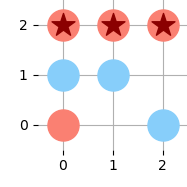

In [11]:
% matplotlib notebook


gameplay=Play(ConnectN(**game_setting), 
              player1=None, 
              player2=Policy_Player_MCTS)


# Training Loop

In [12]:
# initialize our alphazero agent and optimizer
import torch.optim as optim

game=ConnectN(**game_setting)
policy = Policy()
optimizer = optim.Adam(policy.parameters(), lr=.01, weight_decay=1.e-4)

## Tenative exercise:
code up the alphazero loss function, defined to be
$$L = \sum_t \left\{ (v^{(t)}_\theta - z)^2  - \sum_a p^{(t)}_a \log \pi_\theta(a|s_t) \right\} + \textrm{constant}$$ 
I added a constant term $\sum_t \sum_a p^{(t)}\log p^{(t)}$ so that when $v_\theta^{(t)} = z$ and $p^{(t)}_a = \pi_\theta(a|s_t)$, $L=0$, this way we can have some metric of progress.

In [13]:
# train our agent

from collections import deque
import MCTS

episodes = 400
outcomes = []
losses = []

!pip install progressbar
import progressbar as pb
widget = ['training loop: ', pb.Percentage(), ' ', 
          pb.Bar(), ' ', pb.ETA() ]
timer = pb.ProgressBar(widgets=widget, maxval=episodes).start()


for e in range(episodes):
    # each episode, initialize a top node for the MCTS
    mytree = MCTS.Node(ConnectN(**game_setting))
    
    vterm = []
    logterm = []
    
    # wehenever the game is not over yet, explore the tree 50 steps
    while mytree.outcome is None:
        for _ in range(50):
            mytree.explore(policy)
        
        current_player = mytree.game.player # keep trac of the player
        
        # v: expected outcome coputed from the tree search
        # nn_v: the critic value evaluating the current board
        # p: a list of prob of taking each action computed from MCTS
        # nn_p: similar to p but dot MCTS basically coming straight from the policy
        mytree, (v, nn_v, p, nn_p) = mytree.next()  # increment to the next tree
        mytree.detach_mother()
        
        
        
        # we need to compute a loss function by comparing p with nn_p and also comparing nn_v the critic value to the acutal
        # outcome of the game which will be recorded when game is over in the '.outcome'
        # first compute the prob times log policy: prob* log pi 
        loglist = torch.log(nn_p)*p # contribute to part of the loss function.
        
        # constant term to make sure if policy result = MCTS result, loss = 0
        constant = torch.where(p>0, p*torch.log(p),torch.tensor(0.))
        logterm.append(-torch.sum(loglist-constant))
        
        vterm.append(nn_v*current_player)        

        
    # we compute the "policy_loss" for computing gradient
    outcome = mytree.outcome
    outcomes.append(outcome)
    
    loss = torch.sum((torch.stack(vterm)-outcome)**2 + torch.stack(logterm))
    optimizer.zero_grad()
    
    
    loss.backward()
    losses.append(float(loss))
    optimizer.step()
    
    if (e+1)%50==0:
        print("game: ",e+1, ", mean loss: {:3.2f}".format(np.mean(losses[-20:])),
              ", recent outcomes: ", outcomes[-10:])
    del loss
    
    timer.update(e+1)
    
    
timer.finish()




game:  50 , mean loss: 6.44 , recent outcomes:  [0, 1, 1, 1, 1, -1, 0, 0, 1, 0]


game:  100 , mean loss: 5.57 , recent outcomes:  [1, 0, -1, 0, 0, 1, 0, 0, 0, 0]


game:  150 , mean loss: 4.99 , recent outcomes:  [0, 0, 0, -1, 0, 0, -1, 0, 0, 0]


game:  200 , mean loss: 4.36 , recent outcomes:  [0, -1, 0, 0, 0, 0, 1, 0, 0, 0]


game:  250 , mean loss: 3.24 , recent outcomes:  [0, 0, -1, 0, 0, 0, 0, 0, 0, 0]


game:  300 , mean loss: 3.91 , recent outcomes:  [1, 1, -1, 0, 0, 1, 0, 0, 0, 1]


game:  350 , mean loss: 1.67 , recent outcomes:  [0, 0, 0, 0, 0, 0, -1, 0, 0, 0]


game:  400 , mean loss: 1.16 , recent outcomes:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


<IPython.core.display.Javascript object>


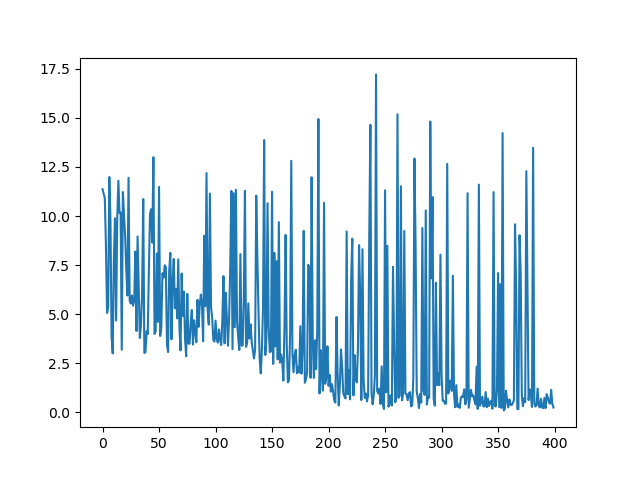

In [14]:
# plot your losses

import matplotlib.pyplot as plt

% matplotlib notebook
plt.plot(losses)
plt.show()


# Play a game against your alphazero agent !

<IPython.core.display.Javascript object>


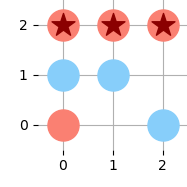

In [18]:
% matplotlib notebook

# as first player
gameplay=Play(ConnectN(**game_setting), 
              player1=None, 
              player2=Policy_Player_MCTS)


<IPython.core.display.Javascript object>


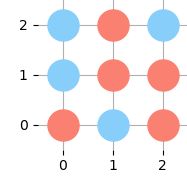

In [25]:
% matplotlib notebook

# as second player

gameplay=Play(ConnectN(**game_setting), 
              player2=None, 
              player1=Policy_Player_MCTS)


<IPython.core.display.Javascript object>


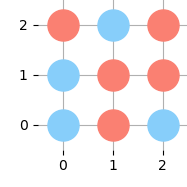

In [27]:
% matplotlib notebook

# AI vs AI

gameplay=Play(ConnectN(**game_setting), 
              player2=Policy_Player_MCTS, 
              player1=Policy_Player_MCTS)
